In [6]:
#!pip install glob2   # if not already installed
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob2
import cv2
%matplotlib inline

class Error(Exception):
    pass

In [7]:
def camera_Calibraton(directory, filename, nx, ny, img_size):
    # Compute camera calibration matrix and distortion coefficients.
    # INPUT:
    # directory, filename = path to repository of camera calibration images
    # nx, ny = Number of inner corners per a chessboard row and column
    # img_size = size of image (tuple)
    # RETURN:
    # dist = camera distortion coefficients 
    # mtx =  camera matrix
    
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    objpoints = []
    imgpoints = []

    # Image List
    images = glob2.glob('camera_cal/' + filename + '*' + '.jpg')  # Change to user's specific path

    # Cycle through list of camera calibration images to search for "chessboard" corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    if (len(objpoints) == 0 or len(imgpoints) == 0):
        raise Error("Calibration Failed")
        
        
    # Find the distortion coefficients and camera matrix
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    return mtx, dist


In [8]:
def undistort_image(img, mtx, dist):
    # Undistort the image, given the distortion cooeficients and camera matrix (that initially distorted the image)
    return cv2.undistort(img, cameraMatrix = mtx, distCoeffs= dist , dst = None, newCameraMatrix= mtx)


In [9]:
def transform(img,src,dst,img_size):
    imga = img.copy()
    # Find the 3x3 transform matrix that maps src -> dst
    M = cv2.getPerspectiveTransform(src, dst)    
    # Apply this transformation matrix to the input image
    warped = cv2.warpPerspective(imga, M, img_size)
    return warped


In [10]:
def find_line_points(img):
    # Find the (x,y) coordinates of the left and right lane lines
    # INPUT:
    # img = grayscale image (following color filtering) of lines within region of interest
    # RETURN:
    # left_x, left_y = (x,y) coordinates of left lane
    # right_x, right_y = (x,y) coordinates of right lane
    # METHOD: Slice both halves of image into rows, and then find the column (of each row) 
    # that has the highest average value. Hence, the more "white" there is (within the grayscale image), 
    # the more likely it is to be a lane line.
    
    # Size of slice
    resolution_h = 10   # ~1% of the image height
    resolution_w = 670  # ~50% of the image width

    # Number of steps for the histogram
    steps_h = img.shape[0] // resolution_h
    steps_w = img.shape[1] // resolution_w

    right_x = []
    right_y = []
    left_x  = []
    left_y  = []

    # The image is now in black/white.
    # Split the image into horizontal blocks, and average across its height at each horizontal coordinate.
    # Then find the horizontal coordinate that has the highest average. That's the coordinate with the most amount of white.

    for j in range(steps_h):

        # Start with RIGHT lanes (START at column = x = resolution_w)
        img_focus = img[j*resolution_h:(j+1)*resolution_h, resolution_w:]
        a1 = np.average(img_focus, axis = 0)

        # Test whether there are any significant points of interest
        if a1.max() < 10:
            continue

        # Save the coordinates
        right_x.append(np.argmax(a1) + resolution_w)              # Horizontal coordinate of the vertical slice with the highest average
        right_y.append( (resolution_h*j + resolution_h*(j+1))//2) # Middle vertical point of the horizontal slice
    

    for j in range(steps_h):

        # Next, find the LEFT lanes (START at first column = x = 0)
        img_focus_L = img[j * resolution_h:(j + 1) * resolution_h, :resolution_w]
        a2 = np.average(img_focus_L, axis=0)

        # Test whether there are any significant points of interest
        if a2.max() < 10:
            continue


        # Save the coordinates
        left_x.append(np.argmax(a2))                                     # Horizontal coordinate of the vertical slice with the highest average
        left_y.append( (resolution_h * j + resolution_h * (j + 1)) // 2) # Middle vertical point of the horizontal slice

    return left_x, left_y, right_x, right_y
    

In [11]:
def polyfit_lines(Lx, Ly, Rx, Ry, poly_degree):
    # Given coordinates of left and right lane lines, find the polynomial function that best-fits the points
    # INPUT:
    # Lx, Ly = coordinates of left lane
    # Rx, Ry = coordinates of right lane
    # poly_degree = degree of polynomial to be fit 
    # RETURN:
    # flag = Bool. 0 if nothing is wrong, 1 otherwise
    # pred_left = horizontal coordinates of predicted position of left lane
    # pred_right = horizontal coordinates of predicted position of right lane

    flag  = 0
    
    if (not Lx or not Ly or not Rx or not Ry):
        # lists are empty, and the color conversions were unsuccesful
        flag = 1
        return flag, _, _
    
    else:
        # Get the polynomial points for the LEFT lane
        z = np.polyfit(Ly,Lx,poly_degree)
        p = np.poly1d(z)
        
        # Extrapolate to top and bottom of the image
        Ly.insert(0,130)                  
        Ly.append(720)                   
        pred_left = p(Ly).astype(np.int64) 

        # Get the polynomial points for the RIGHT lane
        z = np.polyfit(Ry, Rx, poly_degree)
        p = np.poly1d(z)
        
        # Extrapolate to top and bottom of the image
        Ry.insert(0,130)
        Ry.append(720)  # Make sure to inclue the point closest to the car
        pred_right = p(Ry).astype(np.int64)

        return flag, pred_left, pred_right


In [12]:
def hls_color_filter(img, side, filter_number):
    # Convert an image from RGB space -> HLS space
    # INPUTS:
    # img = image in RGB space
    # side = (left or right) lane line
    # filter_number = attempt
    # RETURNS:
    # Image after the appropriate (left/right,attempt = 1/2) filter has been applied
    
    image = img.copy()
    # Convert original image from RGB -> HLS space
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    plt.imsave("./curved_line/converted.jpg", converted)
    if (side == "right"):
        # Search for right lanes (white)
        if (filter_number == 1):
            # Optimized to find WHITE in most images – doesn't always catch 
            # LOW RESOLUTION points in upper parts of image
            lower = np.uint8([13, 150, 100])
            upper = np.uint8([25, 255, 255])
            
        else:
            # Optimized to find WHITE in UPPER halves of images
            lower = np.uint8([100, 110, 0])
            upper = np.uint8([130, 250, 255])
            
        mask = cv2.inRange(converted, lower, upper)

    if (side == "left"):
        # Search for left lanes (yellow)
        if (filter_number == 1):
            # Optimized to find YELLOW in most images – doesn't always catch 
            # LOW RESOLUTION points in upper parts of image      
            lower = np.uint8([5, 100, 100])
            upper = np.uint8([35, 255, 255])    

        else:
            # Optimized to find YELLOW in UPPER halves of images
            lower = np.uint8([20, 130, 0])
            upper = np.uint8([35, 150, 255])   
            
        mask = cv2.inRange(converted, lower, upper)

    return cv2.bitwise_and(converted,converted, mask = mask)


In [23]:
def find_lanes(trans, attempt):
    # Find lanes from a transformed image
    # INPUT: 
    # trans = transformed, undistorted, image. 
    # attempt = 1 or 2, different color filters. Run second filter (attempt = 2) if the first didn't produce good results
    # RETURN:
    # Lx, Ly = Coordinates of left lane
    # Rx, Ry = Coordinates of right lane
    # METHOD: 
    # 1) Creates separate left- and right-halves of the image, 
    # 2) converts both to HLS space, 
    # 3) applies filters to isolate left (yellow) and right (white) lines, 
    # 4) convert halves to grayscale, and rejoin halves
    # 5) constrain grayscale to region of interest
    # 6) send to find_lane_points function


    
    trans_left = trans.copy()
    trans_right = trans.copy()
    
    # Set half of image to black
    trans_left[:,641:,:] = 0
    trans_right[:,0:640,:] = 0    
   
    # Convert RGB space -> HLS space
    if (attempt == 1):
        # First color filter
        trans_HLS_l  = hls_color_filter(trans_left, side = "left", filter_number = attempt)
        trans_HLS_r  = hls_color_filter(trans_right, side = "right", filter_number = attempt)
    else:
        # Second color filter – use only if the first didn't produce enough points
        trans_HLS_l  = hls_color_filter(trans_left, side = "left", filter_number = attempt)
        trans_HLS_r  = hls_color_filter(trans_right, side = "right", filter_number = attempt)

    # Convert HSV space -> Grayscale, and combine halves
    trans_GRAY_left = cv2.cvtColor(trans_HLS_l, cv2.COLOR_RGB2GRAY)
    trans_GRAY_right = cv2.cvtColor(trans_HLS_r, cv2.COLOR_RGB2GRAY)
    trans_GRAY = cv2.bitwise_or(trans_GRAY_left,trans_GRAY_right)

    # Apply mask to constrain to region of interest
    vertices1 = np.array([[[0, 720],
                          [450, 130],
                          [700, 130],
                          [450, 720]]], dtype=np.int32)
    vertices2 = np.array([[[930, 720],
                          [700, 130],
                          [1000, 130],
                          [1200, 720]]], dtype=np.int32)
    img_black = np.zeros_like(trans_GRAY)
    mask = cv2.fillPoly(img_black, vertices1, 255)
    mask = cv2.fillPoly(img_black, vertices2, 255)
    trans_ROI = cv2.bitwise_and(trans_GRAY, mask)
    plt.imsave("./curved_line/trans_ROI.jpg", trans_ROI, cmap = "gray")

    # Find (row, column) values of left and right lanes
    Lx, Ly, Rx, Ry = find_line_points(trans_ROI)

    return Lx, Ly, Rx, Ry
    


In [21]:
def pipeline(img):
    # Full pipeline to find curved lines and produce shaded area
    # INPUT:
    # img = a raw image from the camera
    # RETURN:
    # the same image with superimposed lane lines and shaded area
    
    global mtx, dist # These are global variables as they are specific to the car's camera, and hence WON'T change
    
    image = img.copy()
    
    p1 = image

    # STEP 1: Undistort the image received from the camera / video feed, 
    # using the camera matrix and distortion coefficients
    undist = undistort_image(image, mtx, dist)
    
    # STEP 2: Transform the undistorted image with the shift from source -> destination to give 
    # a "close up" of the distant road
    src =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
    dst =  np.float32([[250,700],[1200,700],[350,150],[1000,150]])  
    img_size = (image.shape[1], image.shape[0])
    trans = transform(undist,src,dst,img_size)
    plt.imsave("./curved_line/trans.jpg", trans)

    # STEP 3: Find the lane points within the transformed image
    Lx, Ly, Rx, Ry = find_lanes(trans,attempt = 1)

    # STEP 4: Check whether enough points in the right lane have been found (if Ry or Ly aren't empty)
    if (not Ry or not Ly or ((max(Ry)- min(Ry))< 205)): 
        # Not enough points found on RIGHT lane: Must run the second filter
        Lx2, Ly2, Rx2, Ry2 = find_lanes(trans, attempt = 2)

        # EXTEND points list
        Lx = Lx2 + Lx
        Ly = Ly2 + Ly
        Rx = Rx2 + Rx
        Ry = Ry2 + Ry

    # STEP 5: Find a QUADRATIC polynomial that fits the real points
    flag, p_left, p_right = polyfit_lines(Lx, Ly, Rx, Ry, poly_degree = 2)

    # STEP 6: Now that lanes have been found, shade the area in-between lanes
    if (flag == 0): 
        # Lines found successfully 
        l1 = np.array((p_left,Ly))
        l2 = np.column_stack(l1)
        r1 = np.array((p_right,Ry))
        r2 = np.column_stack(r1)
        r2 = r2[::-1]
        c = np.concatenate((r2,l2))
        
        # Shade with light green
        img_black2 = np.zeros_like(trans)
        img_with_poly = cv2.fillPoly(img_black2,[c], color = (111,212,107))

        # Draw the left and right lines with thick colored lines
        cv2.polylines(img_with_poly, [l2], isClosed = False, color = (0,255,0), thickness= 20)
        cv2.polylines(img_with_poly, [r2], isClosed = False, color = (0,0,255), thickness= 20)
        
        # STEP 7: Transform shaded area + lines BACK to normal perspective by reversing the previous distortion 
        # (i.e. destination -> source)
        back_transform = transform(img_with_poly, src=dst, dst=src, img_size=img_size)
        plt.imsave("./curved_line/final.jpg", cv2.addWeighted(image,0.7,back_transform,0.3,0))
        # STEP 8: Blend with the original (undistorted) image
        return cv2.addWeighted(image,0.7,back_transform,0.3,0)

    else:
        # Lines found unsuccessfully        
        return image



In [15]:
# Find the camera distortion coefficients and camera matrix
mtx, dist = camera_Calibraton(directory='camera_cal', 
                              filename='calibration',
                              nx=9,
                              ny=6,
                              img_size=(720, 1280))

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 4)


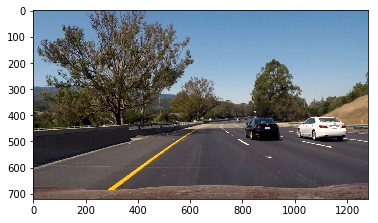

In [19]:
# Read/display a sample image together with print summary statistics
img = mpimg.imread('output/challenge_static26.jpg')
print('This image is:', type(img), 'with dimensions:', img.shape)
plt.imshow(img)

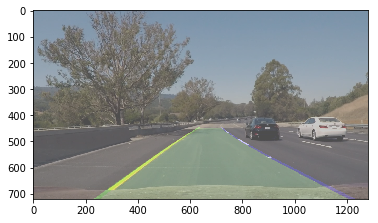

In [24]:
# Show the same image with the shaded, curved, area
plt.imshow(pipeline(img))

In [16]:
# Prepare the video 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
# Make the video
white_output = 'challenge_output.mp4'
# clip1 = VideoFileClip("solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/challenge.mp4")
# clip1.save_frame("output/challenge_static2.jpg",5.8)
# clip1.save_frame("output/challenge_static3.jpg",5.85)
# clip1.save_frame("output/challenge_static4.jpg",5.90)
# clip1.save_frame("output/challenge_static5.jpg",5.95)
# clip1.save_frame("output/challenge_static6.jpg",6)
# clip1.save_frame("output/challenge_static7.jpg",6.05)
# clip1.save_frame("output/challenge_static8.jpg",6.1)

white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████| 251/251 [00:19<00:00, 13.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 33.8 s, sys: 3.96 s, total: 37.8 s
Wall time: 19.8 s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
### THESE ARE UNUSED FUNCTIONS THAT ARE HELPFUL FOR VISUALIZING VARIOUS STAGES OF THE CODE

def show_points(img, x_points, y_points, marker_size):
    # Plot the (x,y) coordinate points on an image image
    imga1 = img.copy()
    # Check inputs have the same lenghts
    assert len(x_points) == len(y_points), "Error in showing points: x_points not same size as y_points"
    # draw crosses at each points
    for i in range(len(x_points)):
        imga1 = (draw_cross(imga1,(x_points[i], y_points[i]), marker_size))

    return imga1

def draw_cross(img,position,marker_size):
    # Draw a cross at chosen position (in (x,y) cartesians) on image in green
    image = img.copy()
    return cv2.drawMarker(image, position, color = [0, 255, 0], thickness=marker_size)


